In [2]:

import pickle

import numpy as np
import pandas as pd
from pathlib import Path
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras

In [3]:
image_dir = Path('images')

In [4]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [5]:
image_df

,Filepath,Label
0,images\paella\1769909.jpg,paella
1,images\steak\2815172.jpg,steak
2,images\bread_pudding\272991.jpg,bread_pudding
3,images\waffles\1854304.jpg,waffles
4,images\french_toast\3009499.jpg,french_toast
...,...,...
10095,images\croque_madame\3389786.jpg,croque_madame
10096,images\poutine\227190.jpg,poutine
10097,images\breakfast_burrito\790446.jpg,breakfast_burrito
10098,images\guacamole\2979136.jpg,guacamole


In [6]:
image_df['Label'].value_counts()

Label
paella            100
steak             100
bread_pudding     100
waffles           100
french_toast      100
                 ... 
caesar_salad      100
chicken_curry     100
chocolate_cake    100
panna_cotta       100
apple_pie         100
Name: count, Length: 101, dtype: int64

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
#outputs = tf.keras.layers.Dense(107, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,451,493 (9.35 MB)

 Trainable params: 193,509 (755.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [18]:
checkpoint_path = "training_1/cp.ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[cp_callback]
)

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7387 - loss: 0.9662
Epoch 1: saving model to training_1/cp.ckpt.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 110s 595ms/step - accuracy: 0.7387 - loss: 0.9662 - val_accuracy: 0.4201 - val_loss: 2.5279
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8294 - loss: 0.6833
Epoch 2: saving model to training_1/cp.ckpt.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 107s 606ms/step - accuracy: 0.8293 - loss: 0.6835 - val_accuracy: 0.3960 - val_loss: 2.6889
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.8768 - loss: 0.5054
Epoch 3: saving model to training_1/cp.ckpt.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 115s 647ms/step - accuracy: 0.8767 - loss: 0.5056 - val_accuracy: 0.4194 - val_loss: 2.7503
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9165 - loss: 0.3693
Epoch 4: saving model to training_1/cp.ckpt.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 107s 606ms/step - accuracy: 0.9165 - los

In [19]:
os.listdir(checkpoint_dir)

['cp.ckpt.weights.h5']

In [20]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

c:\Users\choi0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [33]:
# Loads the weights
model.load_weights(checkpoint_path)
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Re-evaluate the model
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

AttributeError: 'NoneType' object has no attribute 'load_weights'

In [22]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step


In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

image_raw = tf.io.read_file("images/apple_pie/134.jpg")
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

print(image_probs)

TypeError: a bytes-like object is required, not 'str'

In [24]:
import pickle

with open('cm.p', 'wb') as f: # 'data.p' 파일에 data를 dump() 메소드를 사용하여 저장
	pickle.dump(cm, f)

with open('clr.p', 'wb') as f: # 'data.p' 파일에 data를 dump() 메소드를 사용하여 저장
	pickle.dump(clr, f)


In [25]:
import pickle

# 저장한 pickle 파일 불러오기
with open("clr.p", 'rb') as f:
	clr = pickle.load(f)

# 저장한 pickle 파일 불러오기
with open("cm.p", 'rb') as f:
	cm = pickle.load(f)

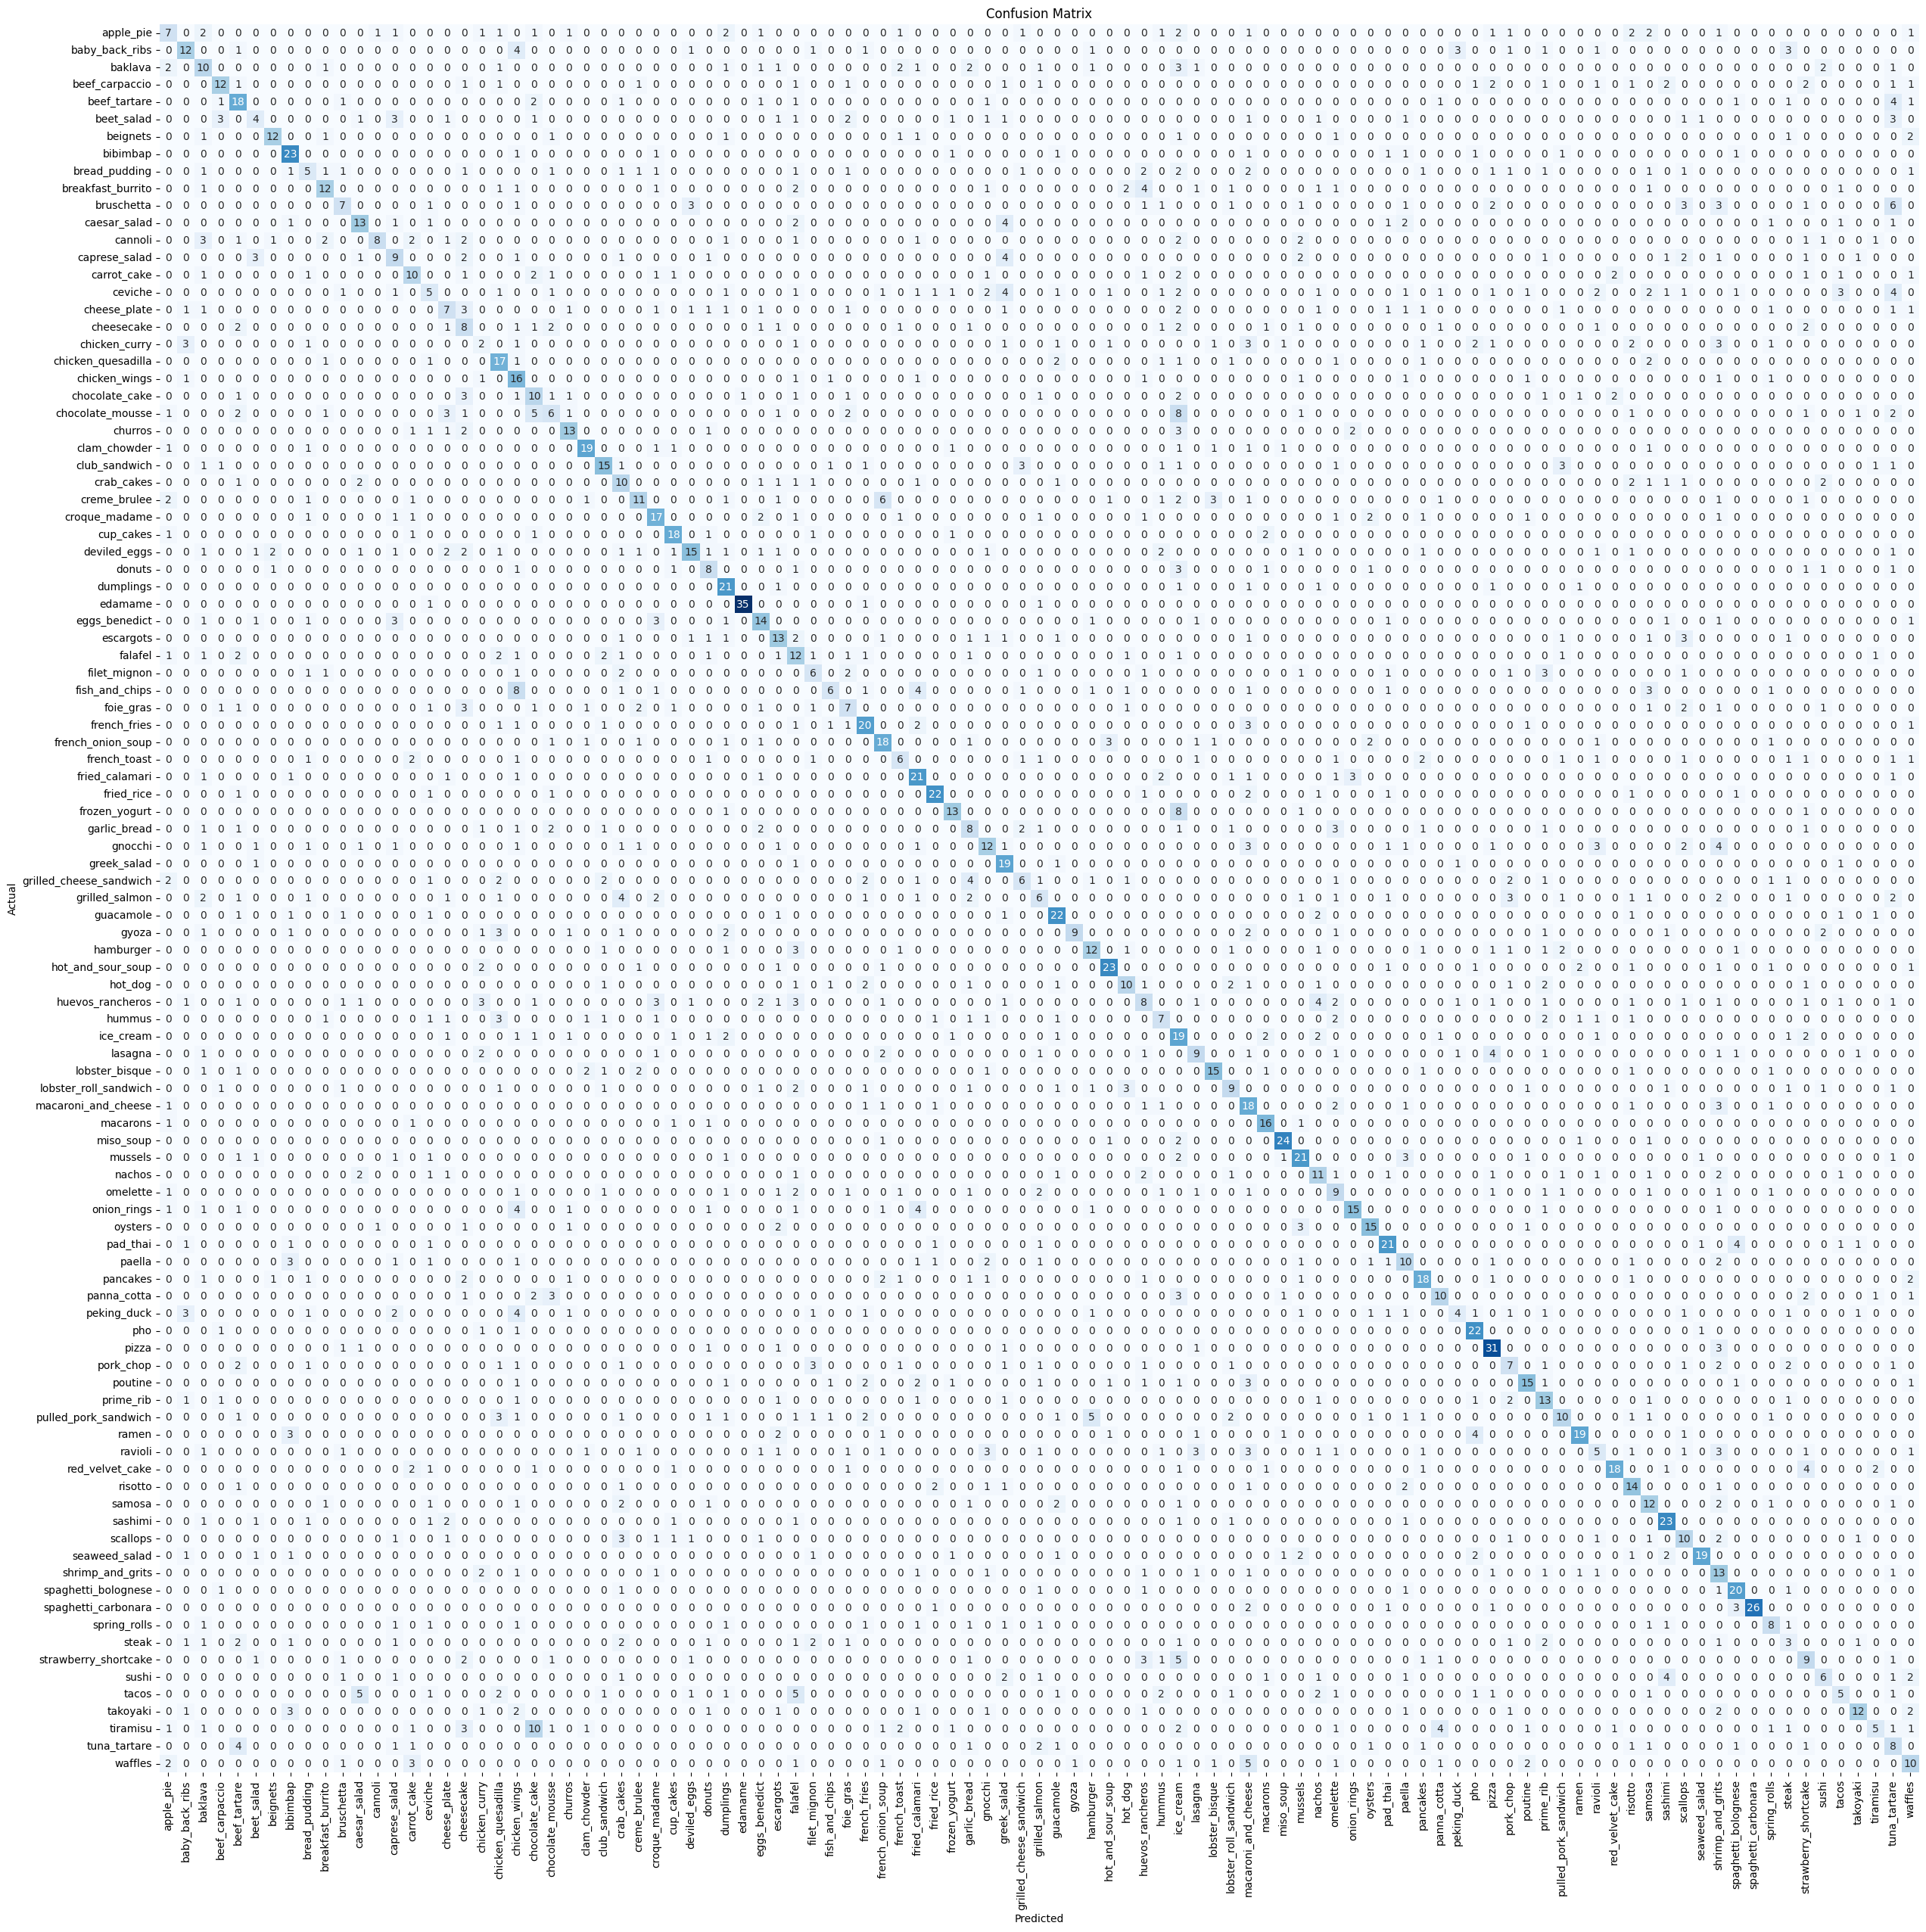

In [26]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.08      0.06      0.07        32
         baby_back_ribs       0.39      0.47      0.42        30
                baklava       0.44      0.13      0.20        31
         beef_carpaccio       0.48      0.50      0.49        32
           beef_tartare       0.53      0.26      0.35        34
             beet_salad       0.57      0.29      0.38        28
               beignets       0.43      0.52      0.47        23
               bibimbap       0.66      0.58      0.61        33
          bread_pudding       0.15      0.17      0.16        30
      breakfast_burrito       0.35      0.35      0.35        31
             bruschetta       0.46      0.19      0.27        32
           caesar_salad       0.33      0.68      0.45        28
                cannoli       0.70      0.23      0.35        30
          caprese_salad       0.19      0.